In [1]:
%matplotlib inline
from pylab import *
from sklearn import datasets
plt.style.use('ggplot')

In [2]:
faces = datasets.fetch_olivetti_faces()

In [3]:
print faces.keys()
print faces.images.shape
print faces.data.shape
print faces.target.shape
print type(faces.images)
print type(faces.data)
print type(faces.target)

['images', 'data', 'target', 'DESCR']
(400, 64, 64)
(400, 4096)
(400,)
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


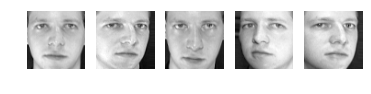

In [4]:
for i in range(5):
    face = faces.images[i]
    subplot(1, 5, i + 1)
    imshow(face.reshape((64, 64)), cmap='gray')
    axis('off')

##Labeling -- Smile/No Smile?

In [5]:
from IPython.html.widgets import interact, ButtonWidget
from IPython.display import display, clear_output

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [6]:
class Trainer:
    def __init__(self):
        self.results = {}
        self.imgs = faces.images
        self.index = 0
        
    def increment_face(self):
        if self.index + 1 >= len(self.imgs):
            return self.index
        else:
            while str(self.index) in self.results:
                print self.index
                self.index += 1
            return self.index
    
    def record_result(self, smile=True):
        self.results[str(self.index)] = smile

In [7]:
trainer = Trainer()

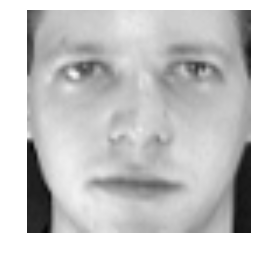

In [8]:
button_smile = ButtonWidget(description='smile')
button_no_smile = ButtonWidget(description='no smile')

def display_face(face):
    clear_output()
    imshow(face, cmap='gray')
    axis('off')

def update_smile(b):
    trainer.record_result(smile=True)
    trainer.increment_face()
    display_face(trainer.imgs[trainer.index])

def update_no_smile(b):
    trainer.record_result(smile=False)
    trainer.increment_face()
    display_face(trainer.imgs[trainer.index])

button_no_smile.on_click(update_no_smile)
button_smile.on_click(update_smile)

display(button_smile)
display(button_no_smile)
display_face(trainer.imgs[trainer.index])

In [9]:
import json

In [10]:
### writing the results of smile/no smile
# with open('results.xml', 'w') as f:
#     json.dump(trainer.results, f)

In [11]:
#reading the results 
results = json.load(open('results.xml'))
trainer.results = results

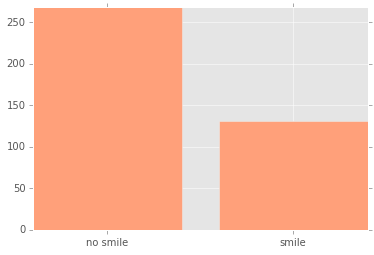

In [12]:
yes = (sum([trainer.results[x] == True for x in trainer.results]))
no = (sum([trainer.results[x] == False for x in trainer.results]))
bar([0, 1], [no, yes], color='lightsalmon')
ylim(0, max(yes, no))
xticks([0.4, 1.4], ['no smile', 'smile']);

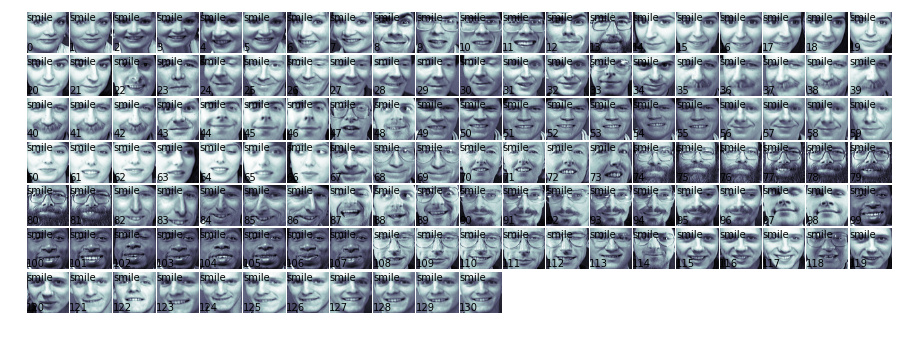

In [13]:
smiling_indices = [int(i) for i in results if results[i] == True]

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(smiling_indices)):
    # plot the images in a matrix of 20x20
    p = fig.add_subplot(20, 20, i + 1)
    p.imshow(faces.images[smiling_indices[i]], cmap=plt.cm.bone)
    
    # label the image with the target value
    p.text(0, 14, "smile")
    p.text(0, 60, str(i))
    p.axis('off')

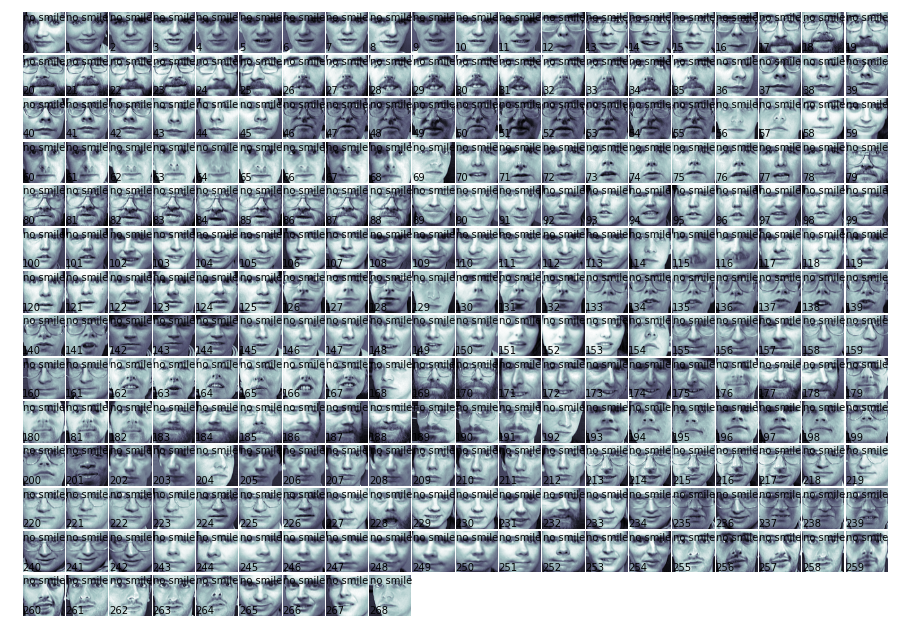

In [14]:
not_smiling_indices = [int(i) for i in results if results[i] == False]

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
for i in range(len(not_smiling_indices)):
    # plot the images in a matrix of 20x20
    p = fig.add_subplot(20, 20, i + 1)
    p.imshow(faces.images[not_smiling_indices[i]], cmap=plt.cm.bone)

    # label the image with the target value
    p.text(0, 14, "no smile")
    p.text(0, 60, str(i))
    p.axis('off')

##Classifier -- SVM

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [14]:
svcmodel = SVC(kernel='linear')

In [15]:
indices = [i for i in trainer.results]
data = faces.data[indices, :]

In [16]:
target = [trainer.results[i] for i in trainer.results]
target = array(target).astype(int32)

In [17]:
print target.shape
print data.shape

(400,)
(400, 4096)


In [18]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
        data, target, test_size=0.25, random_state=0)

In [19]:
from sklearn.cross_validation import cross_val_score, KFold
from scipy.stats import sem

def evaluate_cross_validation(clf, X, y, K):
    # create a k-fold cross validation iterator
    cv = KFold(len(y), K, shuffle=True, random_state=0)
    # by default the score used is the one returned by score method of the estimator (accuracy)
    scores = cross_val_score(clf, X, y, cv=cv)
    print (scores)
    print ("Mean score: {0:.3f} (+/-{1:.3f})".format(
        np.mean(scores), sem(scores)))

In [20]:
evaluate_cross_validation(svcmodel, X_train, y_train, 5)

[ 0.78333333  0.83333333  0.75        0.85        0.9       ]
Mean score: 0.823 (+/-0.026)


In [21]:
from sklearn import metrics

def train_and_evaluate(clf, X_train, X_test, y_train, y_test):
    
    clf.fit(X_train, y_train)
    
    print ("Accuracy on training set:")
    print (clf.score(X_train, y_train))
    print ("Accuracy on testing set:")
    print (clf.score(X_test, y_test))
    
    y_pred = clf.predict(X_test)
    
    print ("Classification Report:")
    print (metrics.classification_report(y_test, y_pred))
    print ("Confusion Matrix:")
    print (metrics.confusion_matrix(y_test, y_pred))

In [22]:
train_and_evaluate(svcmodel, X_train, X_test, y_train, y_test)

Accuracy on training set:
1.0
Accuracy on testing set:
0.85
Classification Report:
             precision    recall  f1-score   support

          0       0.86      0.90      0.88        62
          1       0.83      0.76      0.79        38

avg / total       0.85      0.85      0.85       100

Confusion Matrix:
[[56  6]
 [ 9 29]]


In [23]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

/Users/oksitosin/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


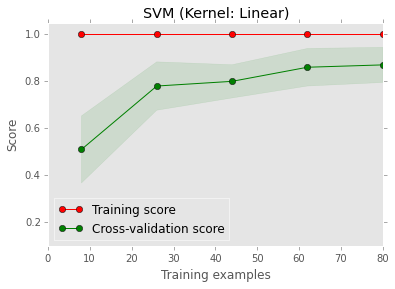

In [24]:
from sklearn.learning_curve import learning_curve
cv = KFold(len(y_test), 5, shuffle=True, random_state=0)
plot_learning_curve(svcmodel, 'SVM (Kernel: Linear)', data, target, (0.1, 1.05), cv=cv, n_jobs=4)

plt.show()

Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[56  6]
 [ 9 29]]
Normalized confusion matrix
[[ 0.9   0.1 ]
 [ 0.24  0.76]]


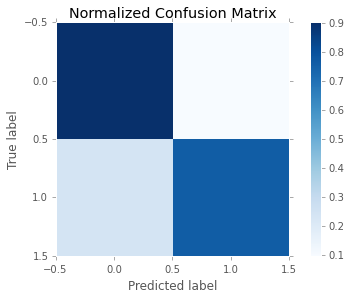

In [25]:
print(__doc__)
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = svcmodel.predict(X_test)    

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
# plt.figure()
# plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
ax = plt.gca()
ax.grid(False)
plot_confusion_matrix(cm_normalized, title='Normalized Confusion Matrix')

plt.show()

In [26]:
from sklearn.metrics import roc_curve, auc

def draw_roc_curve(model, X_train, X_test, y_train, y_test):   
    
    try:
        y_score = model.fit(X_train, y_train).predict_proba(X_test)[:,1]
    except:
        y_score = model.fit(X_train, y_train).decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    # Plot of a ROC curve for a specific class
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

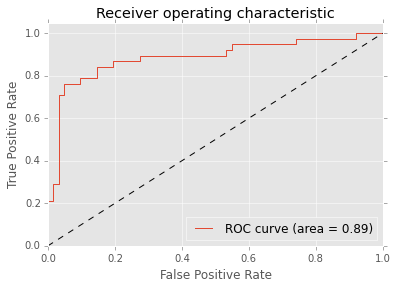

In [27]:
draw_roc_curve(svcmodel, X_train, X_test, y_train, y_test)

##OpenCV - Face Detection

(-0.5, 399.5, 599.5, -0.5)

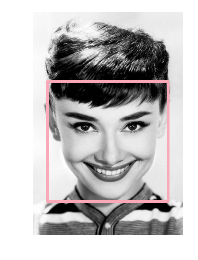

In [29]:
import cv2
#create haar cascade
faceCascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
imgname = 'audrey.png'
image = cv2.imread(imgname)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


faces = faceCascade.detectMultiScale(
    gray,
    scaleFactor=1.1,
    minNeighbors=5,
    minSize=(30, 30),
    flags = cv2.cv.CV_HAAR_SCALE_IMAGE)

from matplotlib.patches import Rectangle
ax = gca()
ax.imshow(gray, cmap='gray')
axis('off')
for (x, y, w, h) in faces:
    
    cv2.rectangle(image, (x, y), (x+w, y+h), (250, 169, 184), 5)

    detected_faces = cv2.resize(gray[y:y+h, x:x+w],(64,64))

plt.imshow(image)
plt.axis('off')

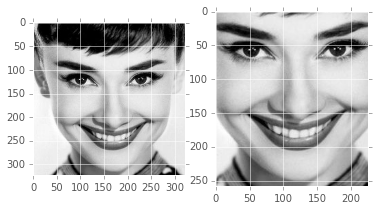

In [30]:
from scipy.ndimage import zoom

original_face = gray[y:y+h, x:x+w]
horizontal_offset = 0.15 * w
vertical_offset = 0.2 * h
face_offset = gray[y+vertical_offset:y+h, 
                      x+horizontal_offset:x-horizontal_offset+w]

subplot(121)
imshow(original_face, cmap='gray')
subplot(122)
imshow(face_offset, cmap='gray')

array([1], dtype=int32)

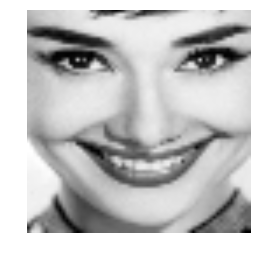

In [31]:
new_face = zoom(face_offset, (64. / face_offset.shape[0], 
                                           64. / face_offset.shape[1]))

new_face = new_face.astype(float32)
new_face /= float(new_face.max())

display_face(new_face[:, :])
smile_prediction = svcmodel.predict(new_face.ravel())
smile_prediction

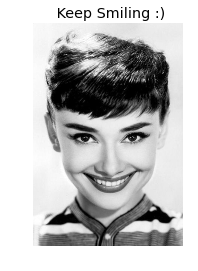

In [32]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

img = Image.open(imgname)

# draw = ImageDraw.Draw(img)
# font = ImageFont.truetype("Times.dfont", 20)

# if smile_prediction == 1:
#     labeled = draw.text((20, 100)," Keep Smiling :)",(255,0,0), font=font)
# elif smile_prediction == 0:
#     labeled = draw.text((200, 0),"Why so serious?",(0,255,255), font=font)

# img.save('sample-out.png')

plt.imshow(img)
axis('off')
if smile_prediction == 1:
    plt.title(' Keep Smiling :)' )
elif smile_prediction == 0:
     plt.title('Why So Serious?' )